In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
sns.set(style="dark")
sns.set_palette("Paired")
plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
font_size = [12,14]

save_figs = False
colors = sns.color_palette("colorblind")

import matplotlib
mkfunc = lambda x, pos: '%1dM' % (x * 1e-6) if x >= 1e6 else '%1dk' % (x * 1e-3) if x >= 1e3 else '%1.1d' % x
mkformatter = matplotlib.ticker.FuncFormatter(mkfunc)

import pandas as pd

In [4]:
def reject_outliers_2(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    print(d)
    print(mdev)
    print(mdev if mdev else 1.)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def pull_max(d):
    _rew = None
    new_mean = []
    for m in d:
        if _rew is None:
            _rew = m
        else:
            if m > _rew:
                _rew = m
        new_mean.append(_rew)
    return new_mean

def process_data(env_path, N=20 , skip_early_stop=False, penalize_early_stop=False, max_steps=1000, debug=False, filename='reward_data.pkl'):
    data = []
    min_size = np.inf
    for i,path in enumerate(glob.glob(env_path + 'seed*/')):
        try: 
            data_set = pickle.load(open(path + filename, 'rb'))
#             print(data_set)
            data_set = np.stack(data_set)
#             print(data_set[-1])
            if data_set[-1,0] < min_size:
                min_size = data_set[-1,0]
            data.append(data_set)
            has_mode_insert_data = False
        except:
            pass
    x_samples = np.linspace(0, min_size, N)
    interp_data,raw_data,final_data = [],[],[]
    xy_idx = [0,1]
    for data_set in data:
        _x, _y = data_set[:,xy_idx].T 
        _steps = np.roll(np.roll(data_set[:,0],-1 ) - data_set[:,0],1)
        _steps[0] = _x[0]
        if debug: 
            print(np.min(_steps),np.max(_steps))
        if skip_early_stop:
            data_idx = (_steps >= max_steps)
            _x, _y = _x[data_idx], _y[data_idx]
        elif penalize_early_stop:
            penalty = max_steps - _steps
            _y = _y + penalty
        interp_data.append(np.interp(x_samples, _x, _y))
        raw_data.append(np.array([_x,_y]))
        for dp in _y[:-3]:
            final_data.append(dp)

    if debug: 
        print(len(interp_data))
    
    final_data = np.stack(final_data)
    mean = np.mean(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)
    data_log = {'x' : x_samples, 'mean' : mean, 'std' : std, 
                'max' : np.max(interp_data, axis=0),
               'min' : np.min(interp_data, axis=0),
               'final' : [np.mean(final_data),"$\pm$",np.std(final_data)],
               '-std' : mean-std,
               '+std' : mean+std, 'data' : interp_data, 'raw_data' : raw_data }
    
    return data_log

def plot_data(ax, log, label, color, linestyle="solid",marker="",raw=False,fill=True):
#     print(len(log['data']))
    ax.plot(log['x'], log['mean'], label=label, linestyle=linestyle, marker=marker, color=color)
    if not fill: 
        all_data = np.array(log['data']).T
        ax.plot(log['x'], all_data, alpha=0.3, linestyle=linestyle, marker=marker, color=color)
        if raw: 
            for data in log['raw_data']:
                ax.plot(data[0], data[1], alpha=0.3, linestyle=linestyle, marker=marker, color=color)    
        
    if fill:
        #     ax.fill_between(log['x'], 
        #                     log['min'], log['max'],
        #                     alpha=0.2)
        ax.fill_between(log['x'], 
                        log['-std'], log['+std'],
                        alpha=0.2, color=color)
    ax.tick_params(axis='both', which='major', labelsize=font_size[0])
    ax.xaxis.set_major_formatter(mkformatter)
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(log['x'][-1]/4))

def plot_measure_data(ax,raw_mig_data,interp=False,N=10):
    x = raw_mig_data[0][:,0]
    if interp: 
        _x = x
        x = np.linspace(x[0], x[-1], N)
        data = np.empty([N,0])
        for y in raw_mig_data: 
            interp_data = np.array([np.interp(x,_x,_y) for _y in y[:,1:].T])
            data = np.hstack([data,interp_data.T])
    else: 
        data = np.empty([10,0])
        for y in raw_mig_data: 
            data = np.hstack([data,y[:,1:]])
    print(data.shape)
    mig_mean= np.mean(data, axis=1)
    mig_min= np.min(data, axis=1)
    mig_max= np.max(data, axis=1)
    mig_std = np.std(data, axis=1)
    ax.plot(x,mig_mean,color='#2f466dff')
    ax.fill_between(x, 
#                     mig_min, mig_max,
                    mig_mean-mig_std, mig_mean+mig_std,
                    color='#2f466dff',
                    alpha=0.2)
    ax.set_xlim([0,x[-1]])
    ax.tick_params(axis='both', which='major', labelsize=font_size[0])
    ax.xaxis.set_major_formatter(mkformatter)
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(x[-1]/4))

# plotting

'reward_data.pkl'

,env,name,mean,,std
0,gym_fhopper,test1,10.59,$\pm$,313.08
1,gym_cheetah,test1,-723.14,$\pm$,2377.38
2,gym_fhopper,test1_buff,19.98,$\pm$,307.76
3,gym_cheetah,test1_buff,-897.67,$\pm$,3552.76
4,gym_fhopper,test2_buff,75.03,$\pm$,297.33
5,gym_cheetah,test2_buff,-3978.18,$\pm$,2283.06


'eval_reward_data.pkl'

,env,name,mean,,std
0,gym_fhopper,test1,79.96,$\pm$,167.89
1,gym_cheetah,test1,5.11,$\pm$,348.37
2,gym_fhopper,test1_buff,111.19,$\pm$,253.45
3,gym_cheetah,test1_buff,-88.14,$\pm$,269.40
4,gym_fhopper,test2_buff,412.71,$\pm$,340.28


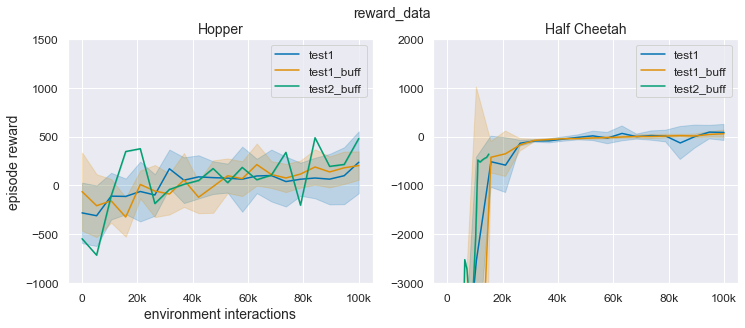

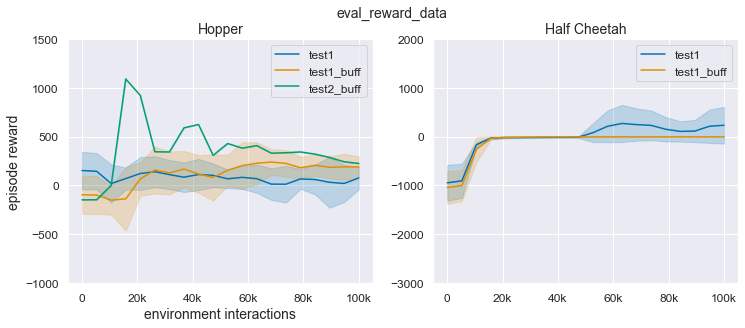

In [7]:
envs = ['gym_fhopper','gym_cheetah'] 
save_name = 'mdgps.pdf'
plot_titles = ['Hopper', 'Half Cheetah']

mods = ['test1','test1_buff','test2_buff']
plot_legend = mods

for filename in ['reward_data.pkl','eval_reward_data.pkl']:
    table = []
    fig, axs = plt.subplots(1, len(envs), figsize=(len(envs)*6,4.5))
    path_dir = '../experiments/'
    for color_idx,(mod,lgd) in enumerate(zip(mods,plot_legend)):
        for i, env in enumerate(envs):
            try:
                data_path = path_dir + '{}/{}/'.format(env,mod)
    #             print(data_path)
                data = process_data(data_path,filename=filename)
                table.append([env,mod,*data['final']])
                plot_data(axs[i], data, lgd, color = colors[color_idx], fill=True, raw=True) 
                axs[i].set_title(plot_titles[i], fontsize=font_size[1])
            except: 
                pass
    axs[0].set_ylabel('episode reward', fontsize=font_size[1])
    #     axs[0].legend(fontsize=font_size[0])
    # axs[-1].legend(bbox_to_anchor=(1,1),loc="upper left", ncol=1, title=lgd_title,title_fontsize=font_size[0],fontsize=font_size[0])
    axs[0].set_xlabel('environment interactions', fontsize=font_size[1])
    for ax,ylims in zip(axs,[[-1000,1500],[-3000,2e3]]): 
        ax.grid()
        ax.set_xlim(0-5e3,1e5+5e3)
        ax.set_ylim(ylims)
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2e4))
        ax.legend(title_fontsize=font_size[0],fontsize=font_size[0])
    plt.suptitle(filename.split('.')[0],fontsize=font_size[1])
    if save_figs:
        plt.savefig(save_name, bbox_inches='tight')
    display(filename)
    df = pd.DataFrame(table,columns=['env','name','mean','','std'])
    df = df.round(2)
    display(df)